# Classification with Cross Validation (CV) using sklearn

The first problem we have to attack is to define a metric we want to maximize (or minimize if it is a loss), and we will use it to select the best (or bests) models and hyperparameters. In order to understand the mechanism, we will code the validation loop by hand, and then we will use sklearn functions which do it automatically.

Although we are only interested in the metric on the validation set, it is interesting to compare it with the metric on the training set, to check the presence of overfitting.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import scipy
import sklearn
# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("notebook")
DATA_PATH = '../data/'

VAL_SPLITS = 4

/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
from plot_utils import plot_confusion_matrix
from cv_utils import run_cv_f1
from cv_utils import plot_cv_roc
from cv_utils import plot_cv_roc_prc

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
# Experimental: Based on LightGMB https://github.com/Microsoft/LightGBM
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn_utils import FeatureSelectorDic

For this part of the project, we will only work with the training set, that we will split again into train and validation to perform the hyperparameter tuning.

We will save the test set for the final part, when we have already tuned our hyperparameters.

In [18]:
df = pd.read_csv(os.path.join(DATA_PATH,'df_train.csv'))
df.drop(columns= df.columns[0:2],inplace=True)
X = df.drop(columns='Class').to_numpy()
y = df['Class'].to_numpy()
idx_to_feat = dict(enumerate([feat for feat in df.drop(columns='Class').columns ]))
feat_to_idx = {feat : idx for idx,feat in idx_to_feat.items()}
del(idx_to_feat)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,TimeScaled,TimeSin,TimeCos,AmountBC
0,-0.829392,1.118573,0.926038,1.163686,0.009824,0.527347,0.173370,0.723997,-0.638939,-0.162923,...,-0.298908,-0.060301,-0.217935,0.291312,0.120779,0,0.460069,-0.480989,0.876727,3.195062
1,-2.814527,1.613321,0.654307,0.581821,0.399491,0.730040,0.456233,-2.464347,0.654797,2.248682,...,-0.329526,-0.307374,-0.440007,-2.135657,0.011041,0,0.266395,-0.204567,-0.978853,3.125269
2,2.105028,-0.700400,-1.338043,-0.596395,-0.395217,-0.755050,-0.276951,-0.291562,-0.965418,1.107179,...,-0.278137,-0.040685,0.789267,-0.066054,-0.069956,0,0.762303,-0.153992,-0.988072,3.421235
3,2.205839,-1.023897,-1.270137,-0.950174,-0.868712,-0.975492,-0.475464,-0.280564,0.503713,0.448173,...,-0.041177,0.089158,1.105794,-0.066285,-0.079881,0,0.879740,-0.998227,0.059524,1.072145
4,2.027090,-0.778666,-1.552755,-0.558679,0.020939,-0.026071,-0.207810,-0.124288,-0.635953,0.817757,...,0.033477,-0.157992,-0.606327,-0.003931,-0.039868,0,0.821649,-0.783558,-0.621319,3.971490


In [9]:
# We set the CV in order to apply the same one to all algorithms
cv = StratifiedShuffleSplit(n_splits=VAL_SPLITS,test_size=0.15,random_state=0)

## Manual cross validation (Exercise, built the CV loop)

We can do it manually, although it is better to define a function to help us iterate the CV over different algorithms and hyperparameters. It is more convenient to create a function, which is `run_cv_f1`

This is a typical CV loop, built from scratch

In [6]:
clf = LogisticRegression(solver='sag',random_state=0,n_jobs=-1)

# We create two eampty lists to save the metrics at each fold for train and validation. 
metrics = []
metrics_train = []
# Loop over the different validation folds
for i,(idx_t, idx_v) in enumerate(cv.split(X,y)):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    
    clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_val)
    metric = f1_score(y_val,y_pred)
    metrics.append(metric)
    
    y_t_pred = clf.predict(X_train)
    metric_train = f1_score(y_train,y_t_pred)
    metrics_train.append(metric_train)
    
    print('{}-fold / {} completed!'.format(i+1,VAL_SPLITS))
    
metric_mean = np.mean(metrics)
metric_std = np.std(metrics, ddof=1)
metric_t_mean = np.mean(metrics_train)
metric_t_std = np.std(metrics_train, ddof=1)
print('Metric value (Train): {:.2f} ± {:.2f}'.format(metric_t_mean,metric_t_std))
print('Metric value(Val): {:.2f} ± {:.2f}'.format(metric_mean,metric_std))

/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1-fold / 4 completed!


/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2-fold / 4 completed!


/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


3-fold / 4 completed!
4-fold / 4 completed!
Metric value (Train): 0.67 ± 0.01
Metric value(Val): 0.69 ± 0.04


/Users/danky/anaconda3/envs/fraud_credit/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The same code can be casted in the form of a function, `run_cv_f1`, which can be found in `cv_utils.py`

In [20]:
feat_sel = FeatureSelectorDic(['V12','AmountBC','V16','V9'],feat_to_idx)
clf_ = LogisticRegression(solver='sag',random_state=0,n_jobs=-1)
clf = make_pipeline(feat_sel,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.61 ± 0.01
F1 value (Val): 0.63 ± 0.06


## Study of the metrics: Confusion matrix, ROC Curve, Precision Recall Curve

Confusion matrix (Counts)
[[36110     6]
 [   31    29]]
Normalized confusion matrix
[[9.99833869e-01 1.66131355e-04]
 [5.16666667e-01 4.83333333e-01]]
Confusion matrix (Counts)
[[36111     5]
 [   33    27]]
Normalized confusion matrix
[[9.99861557e-01 1.38442795e-04]
 [5.50000000e-01 4.50000000e-01]]
Confusion matrix (Counts)
[[36112     4]
 [   32    28]]
Normalized confusion matrix
[[9.99889246e-01 1.10754236e-04]
 [5.33333333e-01 4.66666667e-01]]
Confusion matrix (Counts)
[[36112     4]
 [   24    36]]
Normalized confusion matrix
[[9.99889246e-01 1.10754236e-04]
 [4.00000000e-01 6.00000000e-01]]


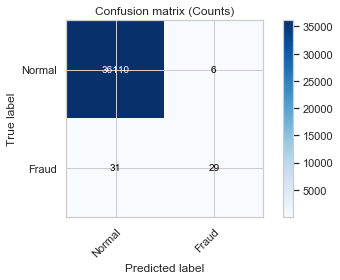

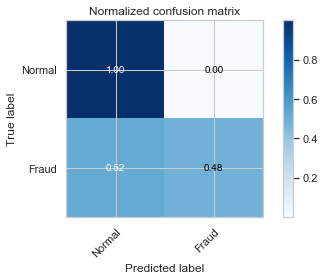

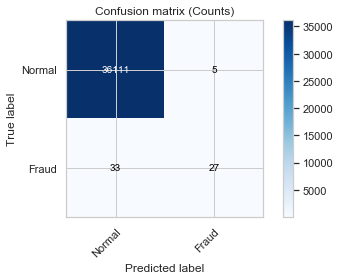

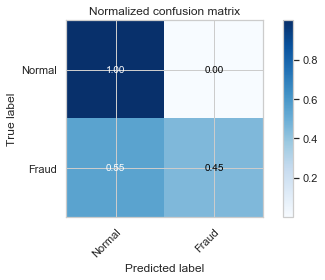

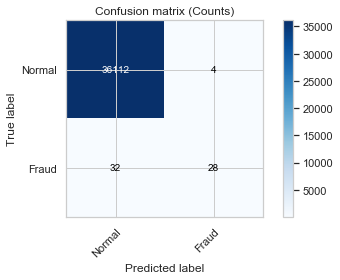

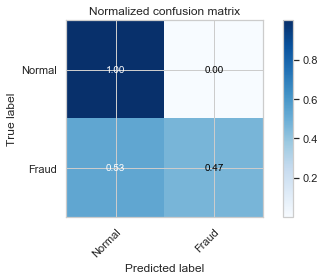

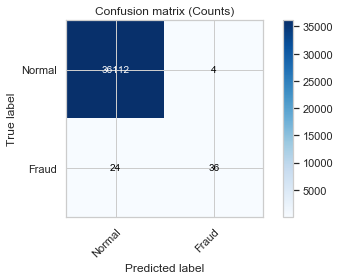

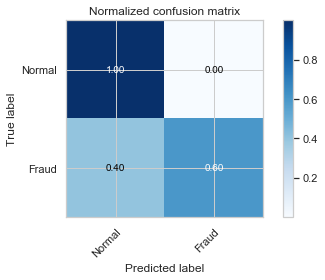

In [21]:
feat_sel = FeatureSelectorDic(['V12','AmountBC','V16','V9'],feat_to_idx)
clf_ = LogisticRegression(solver='sag',random_state=0,n_jobs=-1)
clf = make_pipeline(feat_sel,clf_)

for idx_train, idx_val in cv.split(X,y):
    clf.fit(X[idx_train],y[idx_train])
    y_pred = clf.predict(X[idx_val])

    plot_confusion_matrix(y[idx_val],y_pred,labels=['Normal','Fraud'])
    plot_confusion_matrix(y[idx_val],y_pred,labels=['Normal','Fraud'],normalize=True)

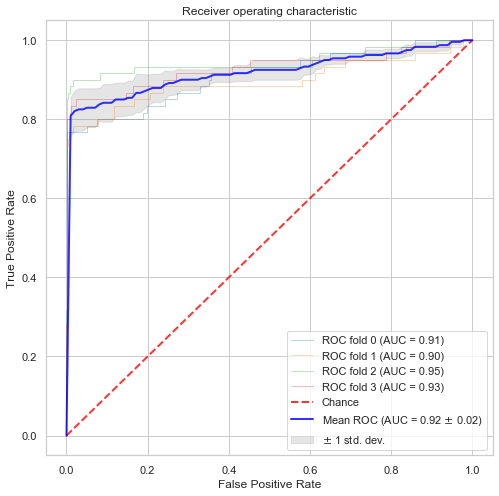

In [22]:
plot_cv_roc(clf,cv,X,y)

/Users/danky/_Proyectos/ModellingWeek/modelling_week_2019/notebooks/cv_utils.py:166: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/Users/danky/_Proyectos/ModellingWeek/modelling_week_2019/notebooks/cv_utils.py:176: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)
/Users/danky/_Proyectos/ModellingWeek/modelling_week_2019/notebooks/cv_utils.py:166: MatplotlibDeprecationWarning: Adding an axes using 

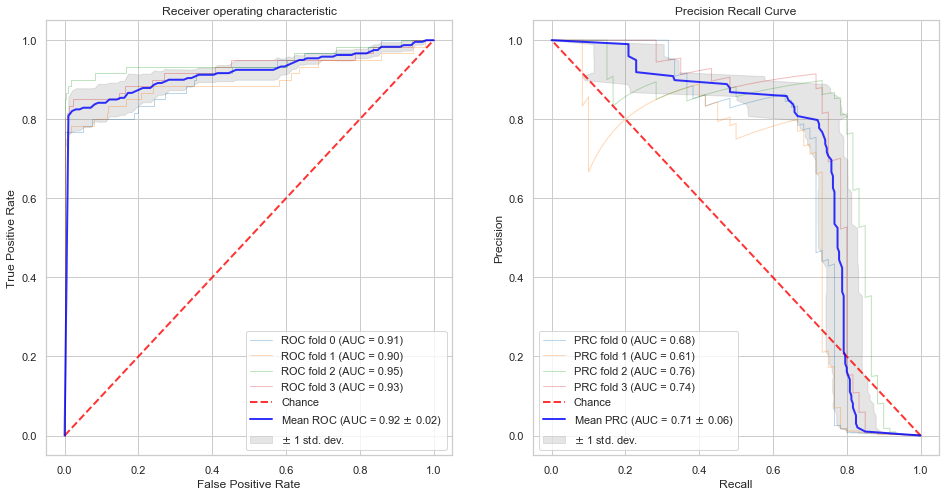

In [23]:
plot_cv_roc_prc(clf,cv,X,y)

## Testing other models

In [24]:
feat_sel = FeatureSelectorDic(['V12','AmountBC','V16','V9'],feat_to_idx)
clf_ = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0)
clf = make_pipeline(feat_sel,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 1.00 ± 0.00
F1 value (Val): 0.77 ± 0.05


In [7]:
for name, value in zip(['V12','AmountBC','V16','V9'],100*clf.feature_importances_):
    print(name,value)

V12 45.168946351201825
AmountBC 8.546067680924292
V16 27.534791680607483
V9 18.750194287266396


In [29]:
feat_sel = FeatureSelectorDic(['V12','AmountBC','V16','V9'],feat_to_idx)
clf_ = AdaBoostClassifier(random_state=0)
clf = make_pipeline(feat_sel,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.68 ± 0.03
F1 value (Val): 0.66 ± 0.08


In [35]:
for name, val in zip(['V12','AmountBC','V16','V9'],100*clf.steps[1][1].feature_importances_):
    print(name,val)

V12 44.0
AmountBC 14.000000000000002
V16 18.0
V9 24.0


In [36]:
std_scaler = StandardScaler()
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = LogisticRegression(solver='lbfgs',random_state=0,class_weight='balanced',n_jobs=-1)
clf = make_pipeline(feat_sel,std_scaler,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.08 ± 0.01
F1 value (Val): 0.08 ± 0.00


In [39]:
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = LogisticRegression(solver='lbfgs',random_state=0,class_weight='balanced',n_jobs=-1)
clf = make_pipeline(feat_sel,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.08 ± 0.01
F1 value (Val): 0.08 ± 0.00



In [37]:
std_scaler = StandardScaler()
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = LogisticRegression(solver='lbfgs',random_state=0,class_weight=None,n_jobs=-1)
clf = make_pipeline(feat_sel,std_scaler,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.67 ± 0.01
F1 value (Val): 0.66 ± 0.05


In [27]:
std_scaler = StandardScaler()
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
clf = make_pipeline(feat_sel,std_scaler,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.87 ± 0.01
F1 value (Val): 0.81 ± 0.07


In [40]:
minmax_scaler = MinMaxScaler()
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
clf = make_pipeline(feat_sel,minmax_scaler,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.85 ± 0.01
F1 value (Val): 0.77 ± 0.06


In [41]:
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
clf = make_pipeline(feat_sel,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.87 ± 0.01
F1 value (Val): 0.80 ± 0.06


In [42]:
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=0)
clf = make_pipeline(feat_sel,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 1.00 ± 0.00
F1 value (Val): 0.80 ± 0.06


In [43]:
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0)
clf = make_pipeline(feat_sel,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 1.00 ± 0.00
F1 value (Val): 0.81 ± 0.06


In [44]:
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0)
clf = make_pipeline(clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 1.00 ± 0.00
F1 value (Val): 0.82 ± 0.04


In [45]:
std_scaler = StandardScaler()
feat_sel = FeatureSelectorDic(['V4','V14','V16','V17','V18','TimeSin','AmountBC'],feat_to_idx)
clf_ = MLPClassifier(solver='lbfgs', alpha=1e-5,
                 hidden_layer_sizes=(16,8,2), random_state=0)
clf = make_pipeline(feat_sel,std_scaler,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.81 ± 0.01
F1 value (Val): 0.78 ± 0.05


In [46]:
std_scaler = StandardScaler()
clf_ = MLPClassifier(solver='lbfgs', alpha=1e-5,
                 hidden_layer_sizes=(16,8,2), random_state=0)
clf = make_pipeline(std_scaler,clf_)

scores = run_cv_f1(clf,cv,X,y)

1-fold / 4 completed!
2-fold / 4 completed!
3-fold / 4 completed!
4-fold / 4 completed!
F1 value (Train): 0.97 ± 0.01
F1 value (Val): 0.79 ± 0.04


## Using sklearn function for CV (Preferred)

Even if it is easy to build the CV loop, and we can change the metric and the outputs in a personalized way, using a `for` loop makes the CV step non parallelizable (we could use the library `multiprocessing`) to solve this, but `sklearn` has implemented such an utility.

These utilities can be found in sklearn's [webpage](https://scikit-learn.org/stable/modules/classes.html#model-validation). Some of them are:
* [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) : Returning the validation score for some given metric.
* [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) : Evaluate metric(s) by cross-validation and also record fit/score times. It can also returns the train metric.

In [47]:
from sklearn.model_selection import cross_validate
from cv_utils import print_scores_cv

In [48]:
std_scaler = StandardScaler()
feat_sel = FeatureSelectorDic(['V9','V14','V16'],feat_to_idx)
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0)
clf = make_pipeline(feat_sel,std_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.82 +- 0.06
train_f1: 1.00 +- 0.00
test_average_precision: 0.78 +- 0.07
train_average_precision: 1.00 +- 0.00
test_roc_auc: 0.92 +- 0.02
train_roc_auc: 1.00 +- 0.00
test_precision: 0.92 +- 0.03
train_precision: 1.00 +- 0.00
test_recall: 0.74 +- 0.08
train_recall: 1.00 +- 0.00


In [49]:
std_scaler = StandardScaler()
clf_ = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
clf = make_pipeline(std_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

KeyboardInterrupt: 

In [ ]:
clf_ = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
clf = make_pipeline(minmax_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

In [50]:
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0)
clf = make_pipeline(clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.82 +- 0.04
train_f1: 1.00 +- 0.00
test_average_precision: 0.81 +- 0.05
train_average_precision: 1.00 +- 0.00
test_roc_auc: 0.94 +- 0.02
train_roc_auc: 1.00 +- 0.00
test_precision: 0.93 +- 0.03
train_precision: 1.00 +- 0.00
test_recall: 0.74 +- 0.05
train_recall: 1.00 +- 0.00


In [51]:
clf_ = HistGradientBoostingClassifier(random_state=0,scoring='f1',n_iter_no_change=50,
                                      learning_rate=0.01,l2_regularization=0.001)
clf = make_pipeline(std_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.75 +- 0.07
train_f1: 0.82 +- 0.04
test_average_precision: 0.77 +- 0.08
train_average_precision: 0.95 +- 0.01
test_roc_auc: 0.96 +- 0.02
train_roc_auc: 0.99 +- 0.00
test_precision: 0.91 +- 0.05
train_precision: 0.97 +- 0.00
test_recall: 0.63 +- 0.09
train_recall: 0.71 +- 0.06


In [52]:
clf_ = HistGradientBoostingClassifier(random_state=0,scoring='f1',n_iter_no_change=50,
                                      learning_rate=0.01,l2_regularization=0.005)
clf = make_pipeline(std_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.77 +- 0.04
train_f1: 0.84 +- 0.01
test_average_precision: 0.79 +- 0.05
train_average_precision: 0.96 +- 0.01
test_roc_auc: 0.96 +- 0.02
train_roc_auc: 0.99 +- 0.00
test_precision: 0.91 +- 0.05
train_precision: 0.97 +- 0.00
test_recall: 0.67 +- 0.03
train_recall: 0.74 +- 0.02


In [53]:
clf_ = HistGradientBoostingClassifier(random_state=0)
clf = make_pipeline(std_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.17 +- 0.20
train_f1: 0.19 +- 0.26
test_average_precision: 0.26 +- 0.30
train_average_precision: 0.24 +- 0.32
test_roc_auc: 0.64 +- 0.14
train_roc_auc: 0.63 +- 0.20
test_precision: 0.12 +- 0.15
train_precision: 0.15 +- 0.21
test_recall: 0.29 +- 0.30
train_recall: 0.28 +- 0.33


In [73]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
feat_sel = FeatureSelectorDic(
    ['V4','V14','V16','V17','V18','TimeSin','AmountBC']
    ,feat_to_idx)
feat_sel_auto = SelectKBest(chi2, k=10)
clf_ = HistGradientBoostingClassifier(random_state=0,scoring='f1',n_iter_no_change=50,
                                      learning_rate=0.01,l2_regularization=0.005)
clf = make_pipeline(minmax_scaler,feat_sel_auto,std_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.74 +- 0.04
train_f1: 0.77 +- 0.03
test_average_precision: 0.78 +- 0.07
train_average_precision: 0.91 +- 0.01
test_roc_auc: 0.96 +- 0.01
train_roc_auc: 0.99 +- 0.00
test_precision: 0.90 +- 0.05
train_precision: 0.95 +- 0.02
test_recall: 0.62 +- 0.05
train_recall: 0.65 +- 0.06


In [62]:
from sklearn.svm import SVC
std_scaler = StandardScaler()
feat_sel = FeatureSelectorDic(
    ['V4','V14','V16','V17','V18','TimeSin','AmountBC']
    ,feat_to_idx)
clf_ = SVC(random_state=0, probability=True)
clf = make_pipeline(feat_sel,std_scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.81 +- 0.06
train_f1: 0.88 +- 0.01
test_average_precision: 0.79 +- 0.06
train_average_precision: 0.90 +- 0.01
test_roc_auc: 0.94 +- 0.01
train_roc_auc: 0.99 +- 0.00
test_precision: 0.91 +- 0.06
train_precision: 0.98 +- 0.01
test_recall: 0.73 +- 0.06
train_recall: 0.80 +- 0.01


In [63]:
scores

{'fit_time': array([1457.18579388,  744.00951409, 1227.25221896, 1594.66873312]),
 'score_time': array([3.38224792, 7.32759595, 6.6629231 , 3.24127603]),
 'test_f1': array([0.75471698, 0.76363636, 0.88073394, 0.8440367 ]),
 'train_f1': array([0.88282504, 0.88424437, 0.86956522, 0.8802589 ]),
 'test_average_precision': array([0.73669667, 0.75148964, 0.87406087, 0.81671161]),
 'train_average_precision': array([0.90684874, 0.90565816, 0.8917859 , 0.89288588]),
 'test_roc_auc': array([0.93120916, 0.93342655, 0.94207184, 0.93920562]),
 'train_roc_auc': array([0.99360607, 0.99011941, 0.99041338, 0.98911905]),
 'test_precision': array([0.86956522, 0.84      , 0.97959184, 0.93877551]),
 'train_precision': array([0.97864769, 0.98214286, 0.96774194, 0.98550725]),
 'test_recall': array([0.66666667, 0.7       , 0.8       , 0.76666667]),
 'train_recall': array([0.80409357, 0.80409357, 0.78947368, 0.79532164])}

#### ExtraTrees w/ Calibration + Weight

In [56]:
from sklearn.calibration import CalibratedClassifierCV
clf_ = HistGradientBoostingClassifier(random_state=0,scoring='f1',n_iter_no_change=50,
                                      learning_rate=0.01,l2_regularization=0.005)
clf = CalibratedClassifierCV(make_pipeline(std_scaler,clf_), cv=cv, method='isotonic')
scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.81 +- 0.04
train_f1: 0.91 +- 0.02
test_average_precision: 0.81 +- 0.07
train_average_precision: 0.98 +- 0.00
test_roc_auc: 0.97 +- 0.01
train_roc_auc: 1.00 +- 0.00
test_precision: 0.88 +- 0.04
train_precision: 0.94 +- 0.02
test_recall: 0.75 +- 0.06
train_recall: 0.87 +- 0.03


In [57]:
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0)
clf = CalibratedClassifierCV(make_pipeline(std_scaler,clf_), cv=cv, method='isotonic')
scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.83 +- 0.03
train_f1: 1.00 +- 0.00
test_average_precision: 0.82 +- 0.05
train_average_precision: 1.00 +- 0.00
test_roc_auc: 0.94 +- 0.01
train_roc_auc: 1.00 +- 0.00
test_precision: 0.90 +- 0.05
train_precision: 1.00 +- 0.00
test_recall: 0.77 +- 0.02
train_recall: 1.00 +- 0.00


In [59]:
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0,class_weight="balanced_subsample")
clf = CalibratedClassifierCV(make_pipeline(std_scaler,clf_), cv=cv, method='isotonic')
scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.84 +- 0.05
train_f1: 1.00 +- 0.00
test_average_precision: 0.81 +- 0.06
train_average_precision: 1.00 +- 0.00
test_roc_auc: 0.94 +- 0.03
train_roc_auc: 1.00 +- 0.00
test_precision: 0.90 +- 0.05
train_precision: 1.00 +- 0.00
test_recall: 0.78 +- 0.05
train_recall: 1.00 +- 0.00


In [60]:
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0,class_weight={0:1,1:10})
clf = CalibratedClassifierCV(make_pipeline(std_scaler,clf_), cv=cv, method='isotonic')
scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.83 +- 0.02
train_f1: 1.00 +- 0.00
test_average_precision: 0.81 +- 0.07
train_average_precision: 1.00 +- 0.00
test_roc_auc: 0.94 +- 0.02
train_roc_auc: 1.00 +- 0.00
test_precision: 0.90 +- 0.03
train_precision: 1.00 +- 0.00
test_recall: 0.78 +- 0.04
train_recall: 1.00 +- 0.00


In [64]:
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0,class_weight={0:1,1:100})
clf = CalibratedClassifierCV(make_pipeline(std_scaler,clf_), cv=cv, method='isotonic')
scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.83 +- 0.03
train_f1: 1.00 +- 0.00
test_average_precision: 0.81 +- 0.05
train_average_precision: 1.00 +- 0.00
test_roc_auc: 0.95 +- 0.03
train_roc_auc: 1.00 +- 0.00
test_precision: 0.88 +- 0.05
train_precision: 1.00 +- 0.00
test_recall: 0.78 +- 0.05
train_recall: 1.00 +- 0.00


In [65]:
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0,class_weight={0:1,1:1000})
clf = CalibratedClassifierCV(make_pipeline(std_scaler,clf_), cv=cv, method='isotonic')
scores = cross_validate(clf,X,y,cv=cv,
                        scoring=['f1','average_precision','roc_auc','precision','recall'],
                        n_jobs=-1, return_train_score=True)
print_scores_cv(scores)

test_f1: 0.84 +- 0.03
train_f1: 1.00 +- 0.00
test_average_precision: 0.81 +- 0.05
train_average_precision: 1.00 +- 0.00
test_roc_auc: 0.93 +- 0.02
train_roc_auc: 1.00 +- 0.00
test_precision: 0.90 +- 0.03
train_precision: 1.00 +- 0.00
test_recall: 0.78 +- 0.05
train_recall: 1.00 +- 0.00


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
feat_select_model = SelectFromModel(lsvc)

scaler = StandardScaler()
clf_ = ExtraTreesClassifier(n_estimators=50,n_jobs=-1,random_state=0)
clf = make_pipeline(feat_select_model,scaler,clf_)

scores = cross_validate(clf,X,y,cv=cv,scoring=['f1','average_precision','roc_auc','precision','recall'],n_jobs=-1, return_train_score=True)
print_scores_cv(scores)